# Simplification

Consider a curve which is represented as a series of points. The problem is to reduce the number of points in the series. 

The Ramer–Douglas–Peucker algorithm is widely known as a method which solves the problem. But let's tackle this problem with persistence.

## Imports

In [1]:
%cd ..

/Users/snopoff/Documents/MIPT/Masters-Thesis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp_rec
from src.topology import topo_simplification
from sklearn.preprocessing import StandardScaler

## Data

As data, let's consider several time series which represent the closing price of QQQ and SPY funds for 10-year long history and the price BTC-USD for 7-year long history.

In [3]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

Shapes of data are:  (2517,) (2517,) (2664,)


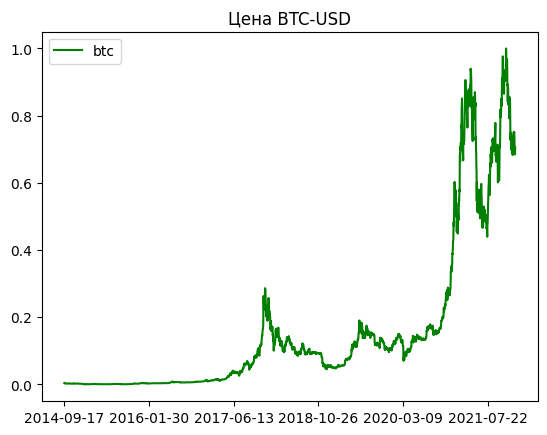

In [4]:
qqq = pd.read_csv('notebooks/data/QQQ.csv').set_index('Date')
spy = pd.read_csv('notebooks/data/SPY.csv').set_index('Date')
btc = pd.read_csv('notebooks/data/BTC-USD.csv').set_index('Date')
qqq_close = normalize(qqq['Adj Close'])
spy_close = normalize(spy['Adj Close'])
btc_close = normalize(btc['Adj Close'])
print('Shapes of data are: ', spy_close.shape, qqq_close.shape, btc_close.shape)
plt.plot(btc_close, c='g', label='btc')
#plt.plot(qqq_close, c='r', label='qqq')
#plt.plot(spy_close, c='b', label='spy')
plt.xticks(range(0,2664,500))
plt.title('Цена BTC-USD')
plt.legend(loc='best')
plt.savefig('images/simplification/btc.jpg')

## Ramer-Douglas-Peucker

The Ramer-Douglas-Peucker algorithm does the following: given a curve that consists of the line segments, it looks for the similar curve with fewer points. The algorithm recursively divides the line. Initially it is given all the points between the first and last point. It automatically marks the first and last point to be kept. It then finds the point that is farthest from the line segment with the first and last points as end points; this point is obviously farthest on the curve from the approximating line segment between the end points. If the point is closer than $\varepsilon$ to the line segment, then any points not currently marked to be kept can be discarded without the simplified curve being worse than $\varepsilon$. 

In [5]:
def compute_rdp(ts, eps=1e-2):
    data = np.vstack([np.array(range(0,ts.shape[0])), ts.to_numpy()]).T
    rdp_res = rdp_rec(data, eps)
    res = ts[list(map(int,rdp_res[:,0]))].sort_index()
    return res

In [6]:
qqq_rdp = compute_rdp(qqq_close)
qqq_rdp.shape

(316,)

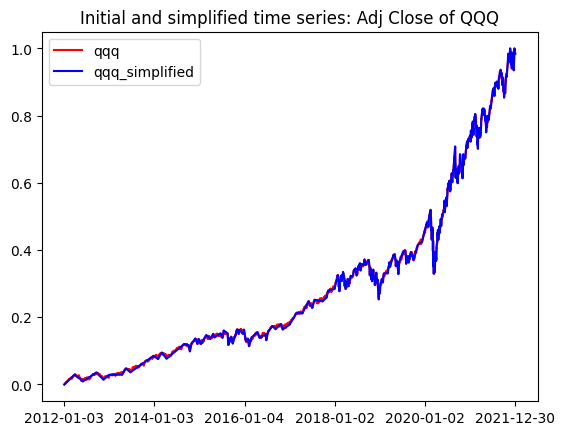

In [7]:
xticks_range = qqq_close.shape[0]
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(qqq_rdp, c='b', label='qqq_simplified')
plt.xticks(range(0, xticks_range, xticks_range // 5))
#plt.xticks(range(0,2517,500))
plt.title('Initial and simplified time series: Adj Close of QQQ')
plt.legend(loc='best')

## Topological Simplification

In [5]:
qqq_top = topo_simplification(qqq_close, distance_to_diagonal=1e-2)
qqq_top.shape

(213,)

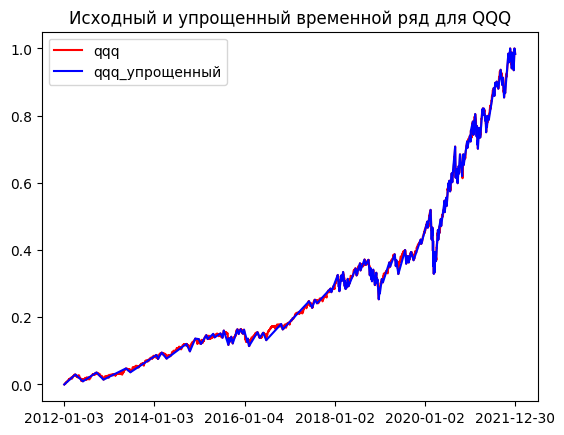

In [12]:
xticks_range = qqq_close.shape[0]
plt.plot(qqq_close, c='r', label='qqq')
plt.plot(qqq_top, c='b', label='qqq_упрощенный')
plt.xticks(range(0, xticks_range, xticks_range // 5))
#plt.xticks(range(0,2517,500))
plt.title('Исходный и упрощенный временной ряд для QQQ')
plt.legend(loc='best')
plt.savefig("simpl_presentation.png")

In [14]:
qqq_close.shape

(2517,)

## Comparison

Let's make a comparison: estimate the quality of simplification via `MSE` of RDP and Topo algorithms

In [10]:
def mse(ts, simpl_ts):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    def find_nearest(array,value):
        idx = np.searchsorted(array, value, side="left")
        if idx > 0 and idx != array.shape[0]:
            return (array[idx-1], array[idx])
        if idx == array.shape[0]:
            return array[idx-1], array[idx-1]
        else:
            return 0, array[idx]
        
    res_value = 0
    for ind in ts.index:
        if ind not in simpl_ts.index:
            ind_left, ind_right = find_nearest(simpl_ts.index, ind)
            value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)
            res_value += (value_at_ind - float(ts[ind]))**2
            
    return res_value / ts.shape[0]

In [11]:
data = {'QQQ': qqq_close.reset_index()['Adj Close'], 'SPY': spy_close.reset_index()['Adj Close'], 'BTC': btc_close.reset_index()['Adj Close']}

In [83]:
%%time
results_rdp = {}
results_topo = {}
for name, d in data.items():
    print("-----\n Dataset is {}".format(name))
    rng = np.linspace(0, 0.75, 30)
    results_rdp[name] = (np.zeros_like(rng),np.zeros_like(rng))
    results_topo[name] = (np.zeros_like(rng),np.zeros_like(rng))
    for i, eps in enumerate(rng):
        rdp = compute_rdp(d,eps)
        topo = topo_simplification(d, distance_to_diagonal=eps)
        topo_mse = mse(d, topo)
        rdp_mse = mse(d, rdp)
        results_topo[name][1][i] = topo_mse
        results_rdp[name][1][i] = rdp_mse
        results_topo[name][0][i] = topo.shape[0]
        results_rdp[name][0][i] = rdp.shape[0]        
        print("Number of points in rdp = {}\t in topo = {}".format(rdp.shape[0], topo.shape[0]))
        print("rdp MSE = {}\t topo MSE = {}".format(rdp_mse, topo_mse))

-----
 Dataset is QQQ
Number of points in rdp = 2516	 in topo = 1244
rdp MSE = 3.873667200421288e-35	 topo MSE = 7.412834371120394e-06
Number of points in rdp = 95	 in topo = 62
rdp MSE = 8.950593226373105e-05	 topo MSE = 0.0002725276289308276
Number of points in rdp = 29	 in topo = 20
rdp MSE = 0.00021126826861368292	 topo MSE = 0.0022023590607331903
Number of points in rdp = 14	 in topo = 12
rdp MSE = 0.0007336398844528427	 topo MSE = 0.002296590561633239
Number of points in rdp = 9	 in topo = 8
rdp MSE = 0.0008507983823802089	 topo MSE = 0.0023780681096348256
Number of points in rdp = 7	 in topo = 4
rdp MSE = 0.002558601020371588	 topo MSE = 0.007704427082700726
Number of points in rdp = 6	 in topo = 4
rdp MSE = 0.0016955212393488662	 topo MSE = 0.007704427082700726
Number of points in rdp = 6	 in topo = 4
rdp MSE = 0.0016955212393488662	 topo MSE = 0.007704427082700726
Number of points in rdp = 4	 in topo = 2
rdp MSE = 0.0020789546877771057	 topo MSE = 0.056832010507438316
Number o

In [90]:
results_rdp['QQQ'][0].shape

(30,)

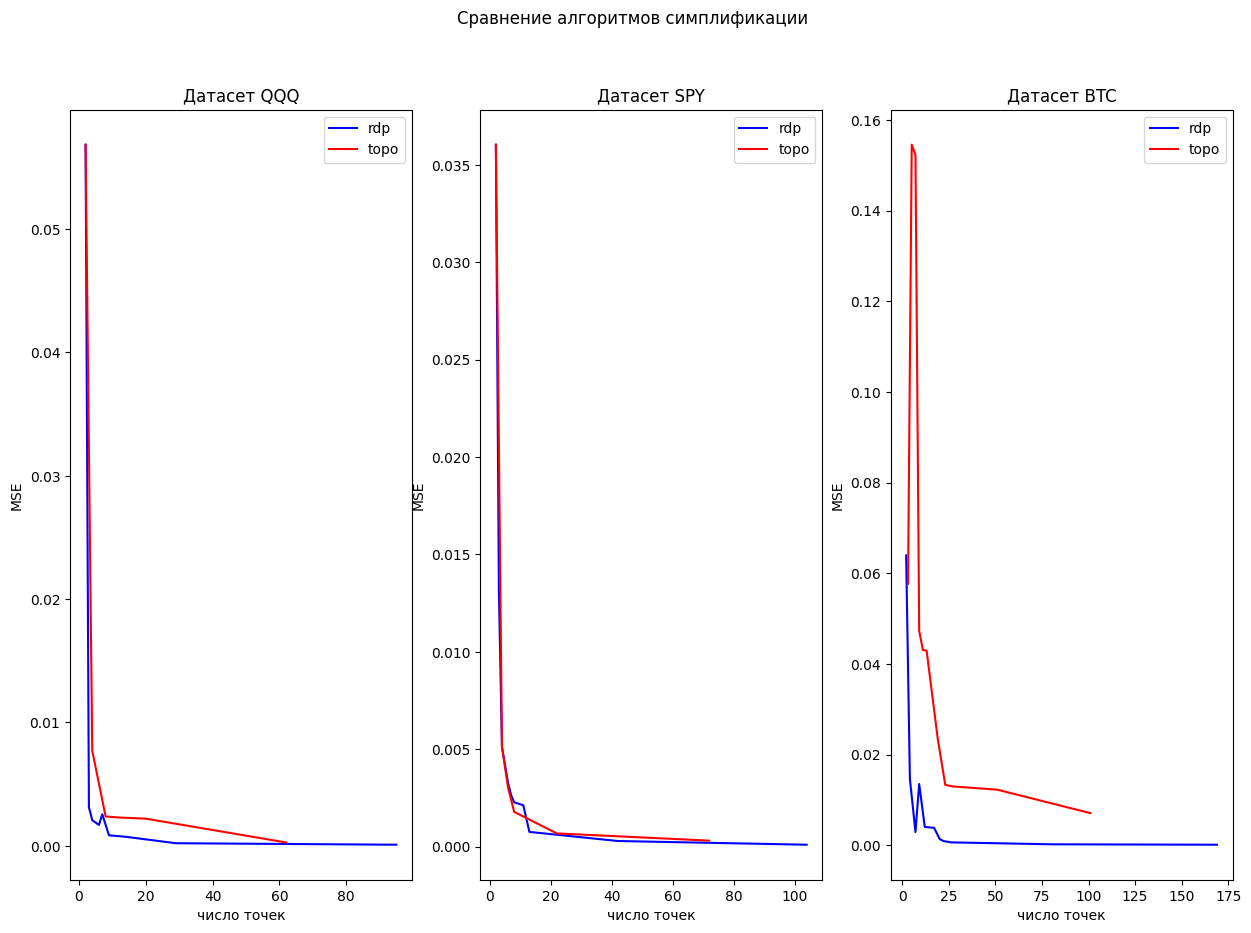

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
fig.suptitle('Сравнение алгоритмов симплификации')
axs = axs.flatten()
for i, name in enumerate(data.keys()):
    axs[i].plot(results_rdp[name][0][1:], results_rdp[name][1][1:], c='b', label='rdp')
    axs[i].plot(results_topo[name][0][1:], results_topo[name][1][1:], c='r', label='topo')
    axs[i].set_xlabel('число точек')
    axs[i].set_ylabel('MSE')
    axs[i].set_title('Датасет {}'.format(name))
    axs[i].legend(loc="best")
fig.savefig('simplification_comparison.jpg')

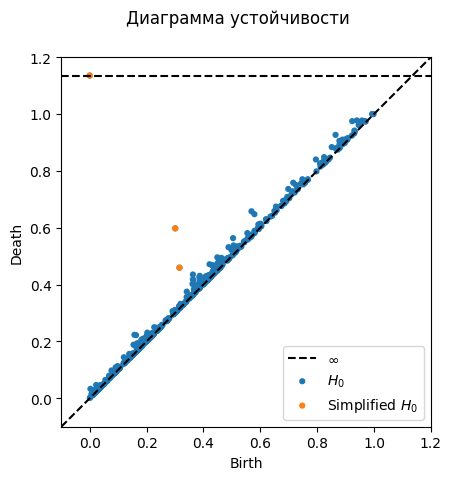

In [61]:
fig = plt.figure()
fig.suptitle('Диаграмма устойчивости')
topo_simplification(spy_close, distance_to_diagonal=0.1, plot_diagram=True)
fig.savefig('topo_simplification_with_parameter_example.png')

QQQ
SPY
BTC


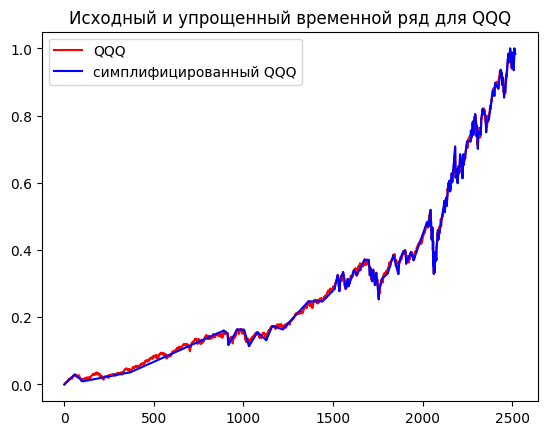

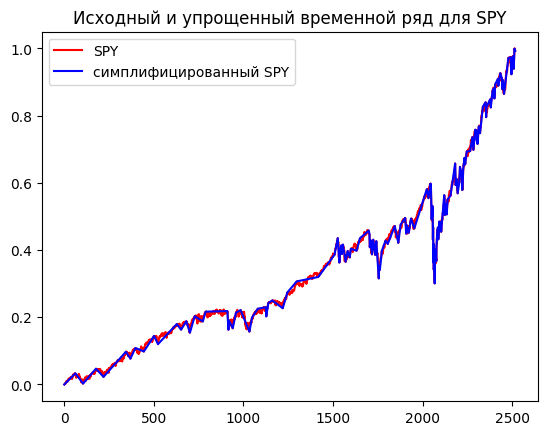

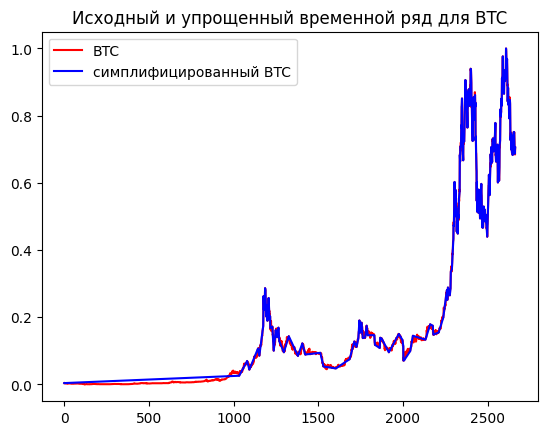

In [18]:
for name, d in data.items():
    fig = plt.figure()
    print(name)
    simpl = compute_rdp(d,eps=0.02)#topo_simplification(d, 0)
    xticks_range = d.shape[0]
    plt.plot(d, c='r', label=name)
    plt.plot(simpl, c='b', label='симплифицированный {}'.format(name))
    plt.xticks(range(0, xticks_range, xticks_range // 5))
    plt.xticks(range(0,2517,500))
    plt.title('Исходный и упрощенный временной ряд для {}'.format(name))
    plt.legend(loc='best')
    fig.savefig('rdp_comparison ' + name + '.png')

## Сlimate Data

In [70]:
climate1516 = normalize(pd.read_json('notebooks/data/climate_15-16.json')[0])
climate1617 = normalize(pd.read_json('notebooks/data/climate_16-17.json')[0])
climate1718 = normalize(pd.read_json('notebooks/data/climate_17-18.json')[0])

In [71]:
data = {'climate_15-16': climate1516, 
        'climate_16-17': climate1617,
        'climate_17-18': climate1718}

In [72]:
%%time
results_rdp = {}
results_topo = {}
for name, d in data.items():
    print("-----\n Dataset is {}".format(name))
    rng = np.linspace(0, 1, 10)
    results_rdp[name] = (np.zeros_like(rng),np.zeros_like(rng))
    results_topo[name] = (np.zeros_like(rng),np.zeros_like(rng))
    for i, eps in enumerate(rng):
        rdp = compute_rdp(d,eps)
        topo = topo_simplification(d, distance_to_diagonal=eps)
        topo_mse = mse(d, topo)
        rdp_mse = mse(d, rdp)
        results_topo[name][1][i] = topo_mse
        results_rdp[name][1][i] = rdp_mse
        results_topo[name][0][i] = topo.shape[0]
        results_rdp[name][0][i] = rdp.shape[0]        
        print("Number of points in rdp = {}\t in topo = {}".format(rdp.shape[0], topo.shape[0]))
        print("rdp MSE = {}\t topo MSE = {}".format(rdp_mse, topo_mse))

-----
 Dataset is climate_15-16
Number of points in rdp = 332	 in topo = 34
rdp MSE = 1.3744275725629881e-30	 topo MSE = nan


/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)
/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)


Number of points in rdp = 86	 in topo = 32
rdp MSE = 0.0016377144987298781	 topo MSE = nan
Number of points in rdp = 37	 in topo = 25
rdp MSE = 0.00456860436062505	 topo MSE = 0.03668595541039493
Number of points in rdp = 16	 in topo = 13
rdp MSE = 0.013649600941230716	 topo MSE = 0.047251683330551214
Number of points in rdp = 8	 in topo = 9
rdp MSE = 0.029647157835647576	 topo MSE = 0.051183776854297904
Number of points in rdp = 6	 in topo = 5
rdp MSE = 0.029320955765176526	 topo MSE = 0.053498981206580774
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.08461370690987557	 topo MSE = 0.08461370690987557
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.08461370690987557	 topo MSE = 0.08461370690987557
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.08461370690987557	 topo MSE = 0.08461370690987557
Number of points in rdp = 2	 in topo = 3
rdp MSE = 0.08774684464694296	 topo MSE = 0.08461370690987557
-----
 Dataset is climate_16-17


/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)


Number of points in rdp = 338	 in topo = 33
rdp MSE = 4.705726717932593e-30	 topo MSE = nan
Number of points in rdp = 66	 in topo = 28
rdp MSE = 0.001720846531319825	 topo MSE = 0.06821822408596534
Number of points in rdp = 33	 in topo = 18
rdp MSE = 0.004721324490982885	 topo MSE = 0.07444255713847236
Number of points in rdp = 18	 in topo = 12
rdp MSE = 0.010834354998789134	 topo MSE = 0.07745905505068822
Number of points in rdp = 10	 in topo = 9
rdp MSE = 0.037160984903480444	 topo MSE = 0.09282858745748705
Number of points in rdp = 6	 in topo = 5
rdp MSE = 0.04907952860917933	 topo MSE = 0.09678751228365212
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.10568651679871167	 topo MSE = 0.10568651679871167
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.10568651679871167	 topo MSE = 0.10568651679871167
Number of points in rdp = 3	 in topo = 3
rdp MSE = 0.10568651679871167	 topo MSE = 0.10568651679871167
Number of points in rdp = 2	 in topo = 3
rdp MSE = 0.05762003330176755	 t

/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)
/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)
/var/folders/h2/nrzj558d5nbgkp248n_sv6gm0000gn/T/ipykernel_10833/271568535.py:16: RuntimeWarning: invalid value encountered in scalar divide
  value_at_ind = (simpl_ts[ind_right] - simpl_ts[ind_left])/(ind_right - ind_left) * ind + (ind_right * simpl_ts[ind_left] - ind_left * simpl_ts[ind_right])/(ind_right - ind_left)


Number of points in rdp = 339	 in topo = 37
rdp MSE = 7.257629588546497e-31	 topo MSE = nan
Number of points in rdp = 64	 in topo = 26
rdp MSE = 0.0017016379329072536	 topo MSE = nan
Number of points in rdp = 29	 in topo = 20
rdp MSE = 0.0048789923889058905	 topo MSE = nan
Number of points in rdp = 13	 in topo = 11
rdp MSE = 0.011789152422795456	 topo MSE = 0.04145068745396951
Number of points in rdp = 9	 in topo = 9
rdp MSE = 0.016752580191340613	 topo MSE = 0.06670041414643432
Number of points in rdp = 4	 in topo = 5
rdp MSE = 0.02991884912701503	 topo MSE = 0.06332906135725241
Number of points in rdp = 4	 in topo = 5
rdp MSE = 0.02991884912701503	 topo MSE = 0.06332906135725241
Number of points in rdp = 2	 in topo = 3
rdp MSE = 0.048042758847274235	 topo MSE = 0.22214176087421938
Number of points in rdp = 2	 in topo = 3
rdp MSE = 0.048042758847274235	 topo MSE = 0.22214176087421938
Number of points in rdp = 2	 in topo = 3
rdp MSE = 0.048042758847274235	 topo MSE = 0.2221417608742193